In [1]:
import open3d as o3d
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from open3d.visualization import rendering
# Util function for loading point clouds|
from raster_pcd2img import pcd2img_torch_v2

# Utils for mesh reconstruction
from alphashape import alphashape
import trimesh
import pymeshfix


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [62]:
def paint_color(pcd, color:str):
    if color =="red":
        color_code = [1,0,0]
    elif color =="green":
        color_code = [0,1,0]
    elif color =="blue":
        color_code = [0,0,1]
    elif color == "grey":
        color_code = [0.9, 0.9, 0.9]
    else:
        color_code = [0,0,0]
    pcd.paint_uniform_color(np.array(color_code))
    return pcd

def o3dpcd2img(pcd, width, height, return_camera=False):
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=480, height=640, visible=False)
    vis.get_render_option().point_size = 10
    vis.add_geometry(pcd)
    view_ctl = vis.get_view_control()
    view_ctl.set_zoom(0.6)
    view_ctl.set_lookat(pcd.get_center())
    view_ctl.set_up((1, 0, 0))  # set the positive direction of the x-axis as the up direction
    view_ctl.set_front((0, 0, 1))  # set the positive direction of the x-axis toward you
    img = vis.capture_screen_float_buffer(True)
    depth = vis.capture_depth_float_buffer(True)
    if return_camera:
       # https://www.open3d.org/html/python_api/open3d.camera.PinholeCameraIntrinsic.html
       cam = view_ctl.convert_to_pinhole_camera_parameters()
       return img, depth, cam.intrinsic.intrinsic_matrix, cam.extrinsic
    vis.destroy_window()
    return img, depth

def pcd_2_mesh(pcd):
    alpha = 0.5
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, alpha)
    mesh.compute_vertex_normals()
    return mesh

def create_2d_mask(width, height, annotations):
    imgRGBWithAnnotations = np.zeros([width, height])
    imgRGBWithAnnotations = cv2.fillPoly(imgRGBWithAnnotations, [annotations], 1)
    return imgRGBWithAnnotations

def segment3D_With2DMask(pcd, mask_2d):
    uv_indices = np.where(mask_2d == 1)
    width, height = mask_2d.shape
    indice_list  = [uv_indices[0][i] * width + uv_indices[1][i] for i in range(len(uv_indices[0]))]
    crop = pcd.select_by_index(indice_list)
    crop.remove_non_finite_points()

def intrinsic3x3_to_4x4(K_3x3):
    """Convert a 3x3 intrinsic matrix to a 4x4 matrix."""
    K_4x4 = np.eye(4)  # Initialize as 4x4 identity matrix
    K_4x4[:2, :3] = K_3x3[:2, :3]  # Copy first two rows
    K_4x4[2, :3] = K_3x3[2, :3]    # Copy third row
    return K_4x4

def reproject3D_to_2d(pcd, intrins, extrinsic):
    points_arr = np.array(pcd.points)
    
    intrins4x4 = intrinsic3x3_to_4x4(intrins) 
    arr = np.hstack((points_arr, np.ones((points_arr.shape[0],1))))
    
    arr_uv = arr @ np.linalg.pinv(extrinsic) @ np.linalg.pinv(intrins4x4)
    print(arr_uv.max())
    # uv = intrins x extrinsic x 3d_coordinates
    # 
    # points_2d = cv2.projectPoints(np.array(pcd.points), )

def project_3d_to_2d(points_3d, K, extrinsic):
    """
    Project 3D points to 2D image coordinates.
    
    Args:
        points_3d: (N, 3) array of 3D points (X, Y, Z).
        K: (3, 3) intrinsic matrix.
        extrinsic: (4, 4) extrinsic matrix [R | t].
    
    Returns:
        points_2d: (N, 2) array of 2D image coordinates (u, v).
        depths: (N,) array of depths (Z in camera space).
    """
    # Convert to homogeneous coordinates (N, 4)
    N = points_3d.shape[0]
    points_hom = np.hstack([points_3d, np.ones((N, 1))])
    
    # Apply extrinsic matrix (world-to-camera)
    points_cam = (extrinsic @ points_hom.T).T  # (4, N) -> (N, 4)
    
    # Drop homogeneous coordinate (now in camera space)
    points_cam = points_cam[:, :3]  # (N, 3)
    
    # Apply intrinsic matrix (camera-to-image)
    points_2d_hom = (K @ points_cam.T).T  # (3, N) -> (N, 3)
    
    # Normalize by depth (Z) to get (u, v)
    depths = points_2d_hom[:, 2]
    points_2d = points_2d_hom[:, :2] / depths[:, None]  # (N, 2)
    
    return points_2d


(3, 3) (4, 4)
<class 'numpy.ndarray'>
462 544


TypeError: select_by_index(): incompatible function arguments. The following argument types are supported:
    1. (self: open3d.cuda.pybind.geometry.PointCloud, indices: list[int], invert: bool = False) -> open3d.cuda.pybind.geometry.PointCloud

Invoked with: PointCloud with 14088 points., [array([   47,    48,    49, ..., 14069, 14073, 14082])]

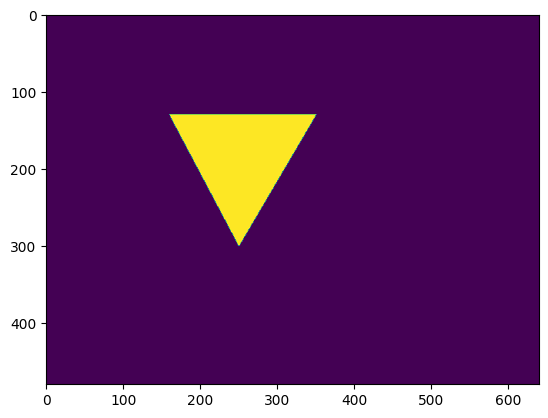

In [66]:
pcd = o3d.io.read_point_cloud("p01e_B_16.ply")
pcd_color = paint_color(pcd, "grey")

width, height = (480, 640)
img, depth = o3dpcd2img(pcd_color, width=width, height=height)
img, depth, intrins, extrinsic = o3dpcd2img(pcd_color, width=width, height=height, return_camera=True)
print(intrins.shape, extrinsic.shape)
print(type(intrins))
plt.imshow(img)

segment2d_anno = np.array([[160, 130], [350, 130], [250, 300]])
mask_2d = create_2d_mask(width=width, height=height, annotations=segment2d_anno)
plt.imshow(mask_2d)

# segment3D_With2DMask(pcd, mask_2d)
pcd_uv = project_3d_to_2d(np.array(pcd.points), intrins, extrinsic).astype(np.int32)
print(pcd_uv[:,0].max(), pcd_uv[:,1].max())
arr_ = mask_2d[pcd_uv[:,0], pcd_uv[:,1]].nonzero()

pcd_selected = pcd.select_by_index(list(arr_))
o3d.visualization.draw_geometries([pcd_selected])
# np.ones((pcd.points.shape[0],1))

In [15]:
import numpy as np

def intrinsic3x3_to_4x4(K_3x3):
    """Convert a 3x3 intrinsic matrix to a 4x4 matrix."""
    K_4x4 = np.eye(4)  # Initialize as 4x4 identity matrix
    K_4x4[:2, :3] = K_3x3[:2, :3]  # Copy first two rows
    K_4x4[2, :3] = K_3x3[2, :3]    # Copy third row
    return K_4x4

# Example 3x3 intrinsic matrix
K_3x3 = np.array([
    [500, 0, 320],
    [0, 500, 240],
    [0, 0, 1]
])

# Convert to 4x4
K_4x4 = intrinsic3x3_to_4x4(K_3x3)

print("3x3 Intrinsic Matrix:")
print(K_3x3)
print("\n4x4 Intrinsic Matrix:")
print(K_4x4)

3x3 Intrinsic Matrix:
[[500   0 320]
 [  0 500 240]
 [  0   0   1]]

4x4 Intrinsic Matrix:
[[500.   0. 320.   0.]
 [  0. 500. 240.   0.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]
